In [1]:
import os
import numpy as np
import cv2 as cv
import glob
from matplotlib import pyplot as plt

This code will download the sample calibration images from OpenCV, if you want to test calibration without uploading your own images.

In [2]:
if not os.path.exists('left01.jpg'):
  for i in [1,2,3,4,5,6,7,8,9,11,12,13,14]:
    cmd = f'wget "https://github.com/opencv/opencv/blob/4.x/samples/data/left{i:02d}.jpg?raw=true" -O left{i:02d}.jpg'
    os.system(cmd)

Take images of a [checkerboard calibration pattern](https://raw.githubusercontent.com/opencv/opencv/refs/heads/4.x/samples/data/chessboard.png) with your camera.  It works well to show the checkerboard on your laptop screen and take photos with your phone, or vice versa.  Hold the checkerboard at different angles and positions and take at least 12 images.  Put the images in the same directory as this notebook.

Set the `PREFIX` variable to match the prefix of your image filenames (like `left` for the OpenCV sample images).

Set the `SUFFIX` variable to match the suffix of your image filenames (like `jpg` or `png`, for example).

In [2]:
PREFIX='images/IMG_'
SUFFIX='jpeg'

In [6]:
images = glob.glob(PREFIX+'*.'+SUFFIX)
print(f'found {len(images)} images:',images)

found 12 images: ['images/IMG_1736.jpeg', 'images/IMG_1737.jpeg', 'images/IMG_1730.jpeg', 'images/IMG_1731.jpeg', 'images/IMG_1728.jpeg', 'images/IMG_1732.jpeg', 'images/IMG_1733.jpeg', 'images/IMG_1729.jpeg', 'images/IMG_1734.jpeg', 'images/IMG_1738.jpeg', 'images/IMG_1739.jpeg', 'images/IMG_1735.jpeg']


This code will use OpenCV's checkerboard detection function to detect the checkerboard in each frame.

Read more about OpenCV's calibration tools [here](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html).

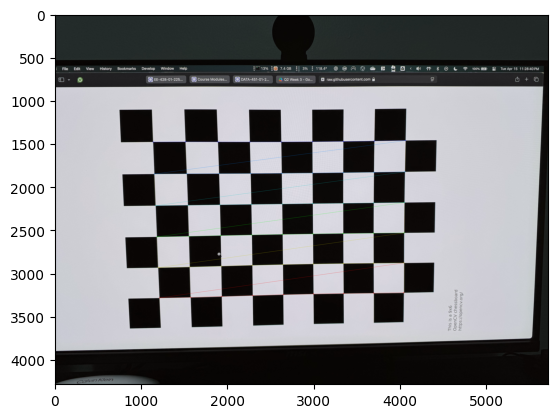

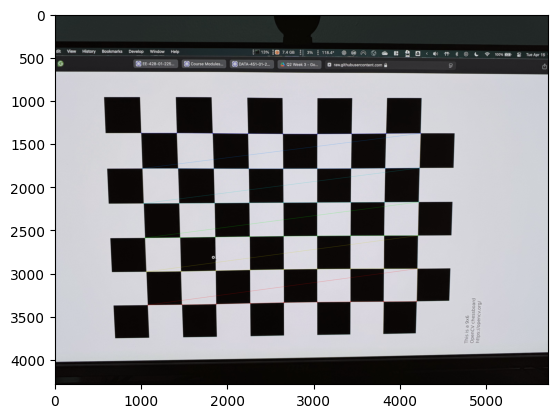

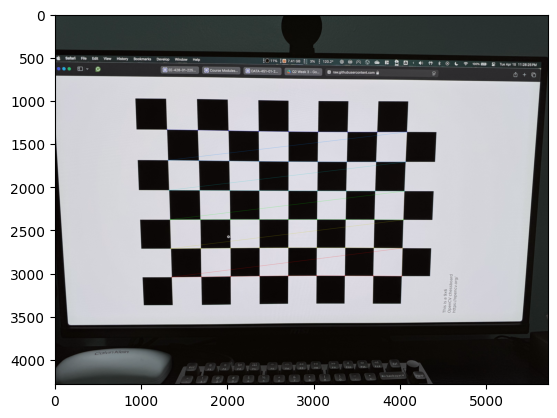

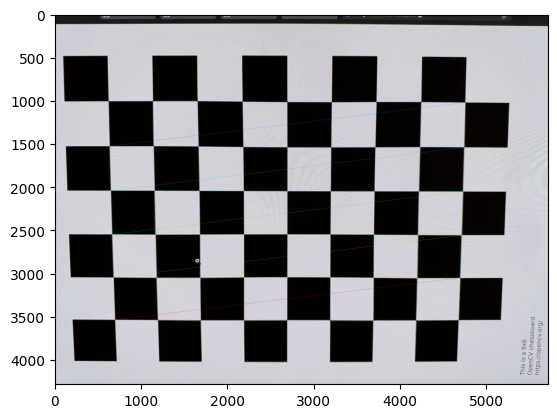

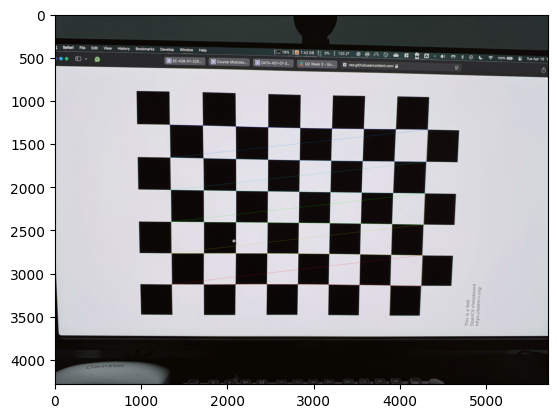

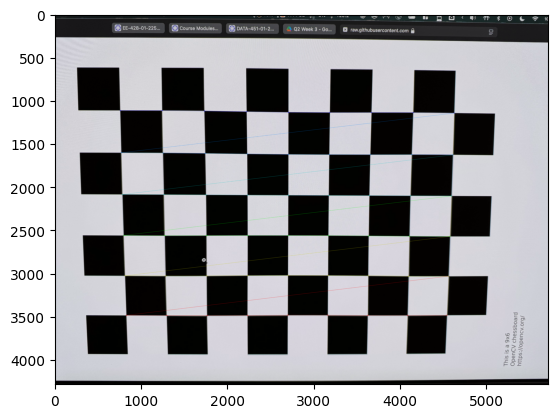

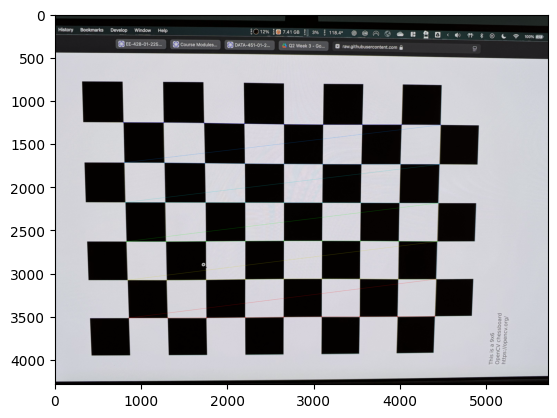

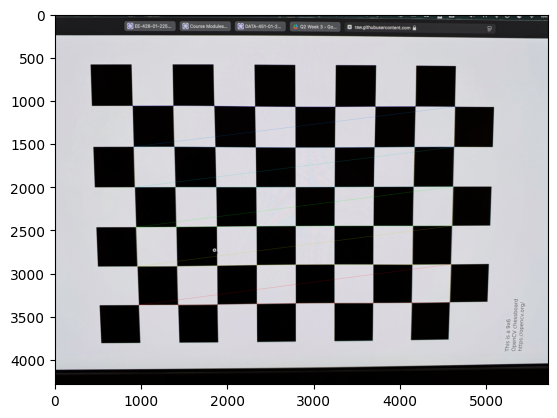

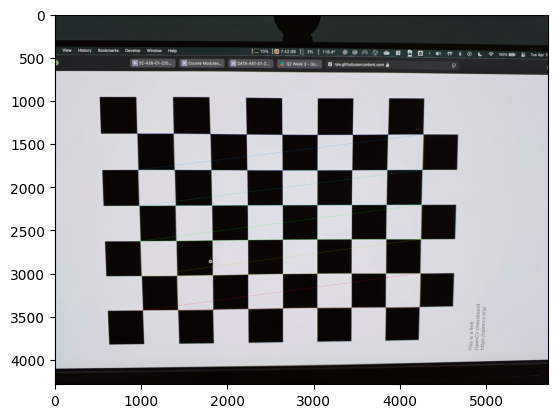

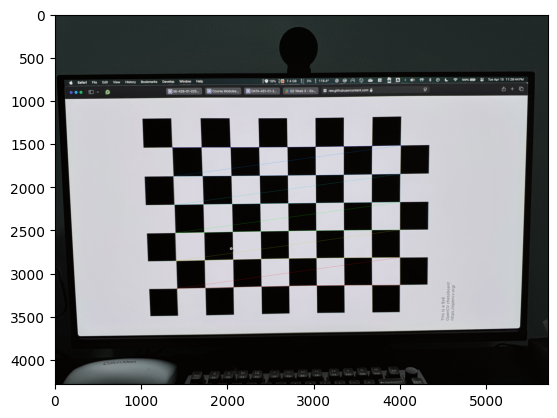

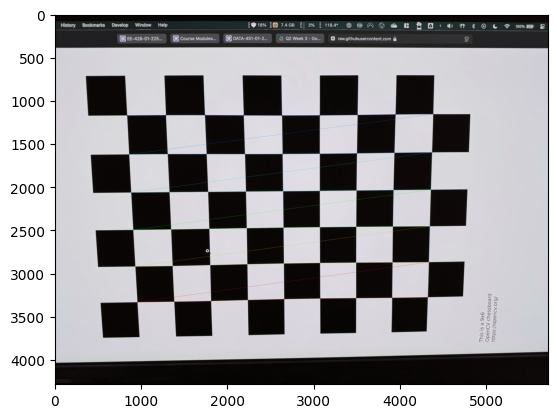

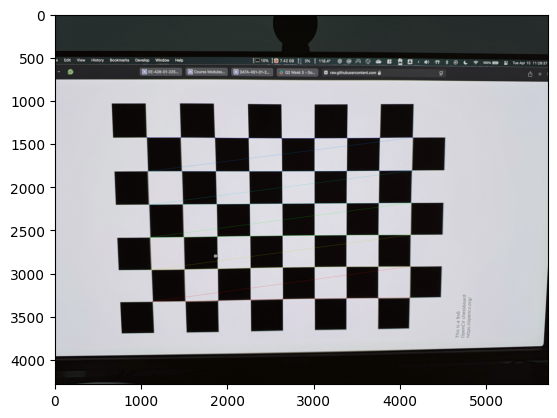

In [7]:
NUM_COLS = 6
NUM_ROWS = 9

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((NUM_COLS*NUM_ROWS,3), np.float32)
objp[:,:2] = np.mgrid[0:NUM_ROWS,0:NUM_COLS].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

for fname in images:
    img = cv.imread(fname)
    # display the image
    plt.imshow(img)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (NUM_ROWS,NUM_COLS), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        cv.drawChessboardCorners(img, (NUM_ROWS,NUM_COLS), corners2, ret)
        plt.imshow(img)
        plt.show()

Now OpenCV will use all of the detected checkerboard patterns to determine the camera calibration parameters.

You can change the flags to control which parameters are estimated.

In [8]:
flags = 0

# fix aspect ratio (same focal length for x and y)
flags |= cv.CALIB_FIX_ASPECT_RATIO

# fix principal point to image center
# flags |= cv.CALIB_FIX_PRINCIPAL_POINT

# zero radial distortion
flags |= (cv.CALIB_FIX_K1|cv.CALIB_FIX_K2|cv.CALIB_FIX_K3|cv.CALIB_FIX_K4|cv.CALIB_FIX_K5|cv.CALIB_FIX_K6)

# zero tangential distortion
flags |= cv.CALIB_ZERO_TANGENT_DIST

ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None, flags=flags)

print(f'reprojection error: {ret}')
print(f'intrinsics matrix:\n{mtx}')
print(f'distortion coefficients: {dist}')

reprojection error: 4.154662117783359
intrinsics matrix:
[[3.36906169e+03 0.00000000e+00 2.88039998e+03]
 [0.00000000e+00 3.36906169e+03 2.02936748e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distortion coefficients: [[0. 0. 0. 0. 0.]]


You can read out the values of the intrinsics matrix as follows:

$$\begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{bmatrix}$$